
# Pendulum

https://www.gymlibrary.ml/environments/classic_control/pendulum/

In [114]:
%matplotlib ipympl

import gym
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
env_name = "Pendulum-v1"
episode_length = 200

## Define Agent

### Do Nothing

In [19]:
class Agent():
    def __init__(self, env):
        pass

    def get_action(self, state):
        action = [0]
        return action

### Try to make it spin counter-clockwise

This may or may not work depending on the initial conditions.

In [28]:
class Agent():
    def __init__(self, env):
        pass

    def get_action(self, state):
        action = [2]
        return action

### Spin in circles

Go either direction

In [45]:
class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)

        if the_d > 0:
            action = [2]
        if the_d < 0:
            action = [-2]
    
        return action

Spin in a particular direction

In [38]:
direction = 'counter-clockwise' # 'counter' or 'counter-clockwise'

class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)
        action = [0]
        if direction == 'clockwise':
            if the_d < 0:
                action = [-2]
        if direction == 'counter-clockwise':
            if the_d > 0:
                action = [2]
    
        return action

### Manual Controller

In [143]:
from enum import Enum

class Phase(Enum):
    SWING_UP = 0
    ARREST = 1
    BALANCE = 2

def get_phase(observation):
    x, y, w = observation
    the = np.arctan2(y,x)
    a = w - state[len(state)-1][1] if len(state) > 0 else 0

    if abs(the) < 0.25 and abs(w) < 3 and abs(a) < 2:
        return Phase.BALANCE
    elif abs(the) < 1.9 and abs(w) > 3:
        return Phase.ARREST
    return Phase.SWING_UP

class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)
        
        action = [0] # Default do nothing

        phase = get_phase(state)
        
        if phase == Phase.SWING_UP:
            if the_d > 0:
                action = [2]
            if the_d < 0:
                action = [-2]
        
        if phase == Phase.ARREST:
            if the_d > 0:
                action = [-2]
            if the_d < 0:
                action = [2]
        
        if phase == Phase.BALANCE:
            # PID control
            factor = 3
            p = 0.4
            d = 0.6
            composite = factor * ((-1 * p * the) + (-1 * d * the_d)) # + i * self.angle_integral
            action = [np.clip(composite, -2, 2)]

    
        return action

### PID Controller

In [125]:
class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)
        self.angle_integral += the
        p = 0.6
        d = 0.4
        i = 0.1
        composite = (-1 * p * the) + (-1 * d * the_d) # + i * self.angle_integral
        action = [np.clip(composite, -2, 2)]
        return action

## Live Plot

/Users/chewchiashaoyuan/.local/share/virtualenvs/openai-gym-ivwuKYuv/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/var/folders/sl/37m0k__51_3_5c5j02w201r40000gn/T/ipykernel_924/3037082995.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which="both")


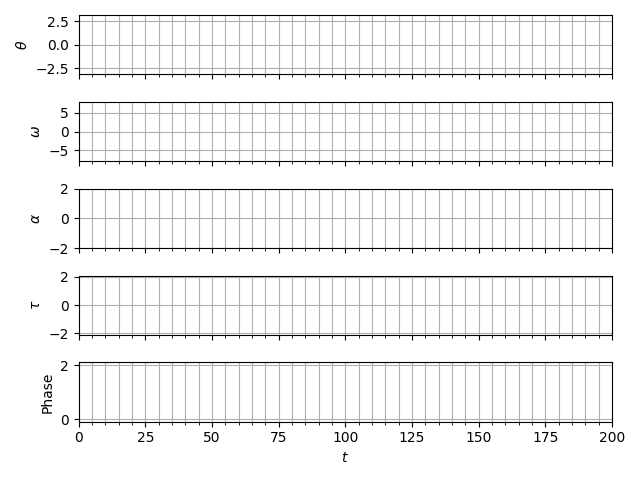

In [123]:
num_subplots = 5
fig, axes = plt.subplots(num_subplots,1)
lines = []

# Set common settings
for i, ax in enumerate(axes):
    ax.grid(b=True, which="both")
    ax.set_xlim(0,episode_length)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
    lines.append(ax.plot([], []))
    if i != len(axes)-1:
        ax.get_xaxis().set_ticklabels([])

axes[0].set_ylabel(r'$\theta$')
axes[0].set_ylim(-np.pi, np.pi)
axes[1].set_ylabel(r'$\omega$')
axes[1].set_ylim(-8, 8)
axes[2].set_ylabel(r'$\alpha$')
axes[2].set_ylim(-2, 2)
axes[3].set_ylabel(r'$\tau$')
axes[3].set_ylim(-2.1, 2.1)
axes[4].set_ylabel('Phase')
axes[4].set_ylim(-0.1, 2.1)

ax.set_xlabel(r'$t$')

fig.tight_layout()

state = []
frames = []

def plot_state(observation, action, frame_no):
    x, y, w = observation
    the = np.arctan2(y,x)
    a = w - state[len(state)-1][1] if len(state) > 0 else 0 
    tau = action[0]
    phase = get_phase(observation)
    state.append([the, w, a, tau, phase.value])
    frames.append(frame_no)
    
    transpose = np.array(state).T
    
    for i in range (num_subplots):
        lines[i][0].set_data(frames, transpose[i])

    fig.canvas.draw()


## Run Environment

In [144]:
env = gym.make(env_name)
agent = Agent(env)
results = list()
final_positions = list()

for i_episode in range(1):
    state.clear()
    frames.clear()
    observation = env.reset()
    for t in range(500):
        env.render()
        action = agent.get_action(observation)
        plot_state(observation, action, t)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            results.append(t+1)
            final_positions.append(observation[0])
            break
            
print(f"Final Results:{results}")
print(f"Final Positions:{final_positions}")
env.close()


Episode finished after 200 timesteps
Final Results:[200]
Final Positions:[0.07213937]


In [89]:
plt.close('all')